<a href="https://colab.research.google.com/github/h40huynh/fake-news-detection/blob/master/Classify_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install tensorflow==1.13.1

In [ ]:
%%capture
import os

import pandas as pd
import numpy as np

from matplotlib import style, pyplot as plt
import seaborn
style.use('seaborn')

from gensim.models import KeyedVectors

import re
from nltk.tokenize import RegexpTokenizer
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
from tensorflow.random import set_random_seed

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score

from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [ ]:
PATH_DATASET = "drive/My Drive/ColabNotebooks/VietnameseFakeNews/CSV/final2.csv"
PATH_EMBEDDING = "drive/My Drive/ColabNotebooks/VietnameseFakeNews/Models/cc.vi.300.vec.gz"
PATH_NEW = "drive/My Drive/ColabNotebooks/VietnameseFakeNews/Models/preproccess.pickle"

Khai báo các hàm cần thiết:


*   clean_text: thực hiện loại bỏ url và các ký tự đặc biệt, sau đó token hóa đoạn text.
*   pad_array: thêm 0 vào các vector để có được độ dài là giống nhau.



In [ ]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    # Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

def pad_array(array, token_len):
    diff_token = token_len - len(array)
    if(diff_token < 0):
        array = array[:token_len] # Truncate
    else:
        # Pad
        array += [0]*diff_token # Pad
        
    return array

def max_token(df, col):
    tokens_numbers = df.apply(lambda row: len(row[col]), axis = 1)
    max_tokens = np.mean(tokens_numbers) + 2 * np.std(tokens_numbers)
    return int(max_tokens)

Load dataset lên

In [ ]:
dataset = pd.read_csv(PATH_DATASET)
dataset.head()

,Unnamed: 0,title,text,label
0,0.0,"V.I.Lê-nin - Nhà tư tưởng vĩ đại, lãnh tụ thiê...",(Chinhphu.vn) - Nhân kỷ niệm 150 năm ngày sinh...,1
1,1.0,Phó Thủ tướng chủ trì họp về phương án tổ chức...,"(Chinhphu.vn) – Ngày 21/4, Phó Thủ tướng Vũ Đứ...",1
2,2.0,Sửa đổi toàn diện Luật Bảo vệ môi trường đáp ứ...,(Chinhphu.vn) - Đây là một trong những yêu cầu...,1
3,3.0,"Bộ Quốc phòng hỗ trợ thiết bị, vật tư phòng dị...",(Chinhphu.vn) - Bộ Quốc phòng Việt Nam hỗ trợ ...,1
4,4.0,"70 năm đoàn kết, đồng hành vì sự nghiệp cách mạng",(Chinhphu.vn) - Lịch sử phát triển 70 năm Hội ...,1


Có thể thấy răng tập dataset bị mất cân bằng khi các nhãn real (1) quá nhiều.

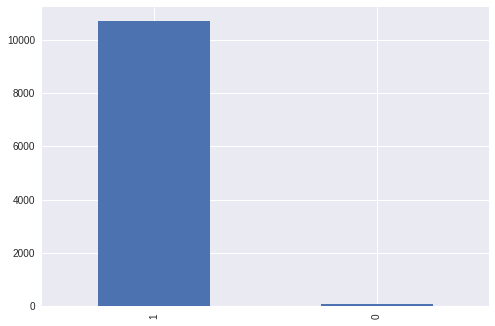

In [ ]:
dataset['label'].value_counts().plot.bar()

# Preproccessing (Tiền xử lý tập dữ liệu)

Dùng hàm clean text đã định nghĩa ở trên lần lượt clean và token hóa title và text.

In [ ]:
# Clean content
dataset['text'] = dataset.apply(lambda row: clean_text(row['text']), axis=1)

# Clean title
dataset['title'] = dataset.apply(lambda row: clean_text(row['title']), axis=1)

In [ ]:
dataset.head()

,Unnamed: 0,title,text,label
0,0.0,"[V, Nhà, tư, tưởng, vĩ, đại, lãnh, tụ, thiên, ...","[Nhân, kỷ, niệm, năm, ngày, sinh, V, Lenin, Nh...",1
1,1.0,"[Phó, Thủ, tướng, chủ, trì, họp, về, phương, á...","[Ngày, Phó, Thủ, tướng, Vũ, Đức, Đam, đã, họp,...",1
2,2.0,"[Sửa, đổi, toàn, diện, Luật, Bảo, vệ, môi, trư...","[Đây, là, một, trong, những, yêu, cầu, được, Ủ...",1
3,3.0,"[Bộ, Quốc, phòng, hỗ, trợ, thiết, bị, vật, tư,...","[Bộ, Quốc, phòng, Việt, Nam, hỗ, trợ, quân, độ...",1
4,4.0,"[năm, đoàn, kết, đồng, hành, vì, sự, nghiệp, c...","[Lịch, sử, phát, triển, năm, Hội, Nhà, báo, Vi...",1


Tìm ra số lượng token tối đa của title và text.

In [ ]:
MAX_LEN_TITLE = max_token(dataset, 'title')
MAX_LEN_TEXT = max_token(dataset, 'text')
print(MAX_LEN_TITLE, MAX_LEN_TEXT)

17 1799


Load FastText để thực hiện vector hóa các token. Với mỗi từ sẽ ứng với 1 index trong từ điển.

In [ ]:
model = KeyedVectors.load_word2vec_format(PATH_EMBEDDING, binary=False, limit=50000)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Vector hóa dataset.

In [ ]:
dataset['text'] = dataset.apply(lambda r: [model.vocab[x].index for x in r['text'] if x in model.vocab], axis=1)
dataset['title'] = dataset.apply(lambda r: [model.vocab[x].index for x in r['title'] if x in model.vocab], axis=1)

In [ ]:
dataset.head()

,Unnamed: 0,title,text,label
0,0.0,"[795, 774, 860, 1399, 3863, 1110, 2870, 3715, ...","[2836, 2828, 3646, 19, 47, 263, 795, 5531, 774...",1
1,1.0,"[665, 11277, 748, 461, 4896, 887, 30, 920, 714...","[277, 665, 11277, 748, 3555, 369, 23529, 22, 8...",1
2,2.0,"[2027, 292, 550, 1328, 1095, 4493, 3314, 855, ...","[335, 7, 14, 13, 24, 374, 553, 12, 578, 2822, ...",1
3,3.0,"[239, 3374, 180, 9310, 2612, 3291, 52, 847, 86...","[239, 3374, 180, 318, 454, 9310, 2612, 271, 50...",1
4,4.0,"[19, 768, 1146, 188, 1210, 109, 69, 2665, 108,...","[1821, 1344, 582, 3905, 19, 885, 774, 481, 318...",1


Để cân bằng lại tập dữ liệu, chúng ta cần generate thêm các dòng có nhãn fake (0) bằng RandomOverSampler của thư viện imblearn.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


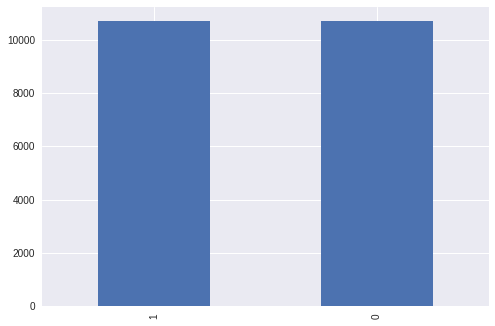

In [ ]:
ros = RandomOverSampler()
x_over, y_over = ros.fit_resample(dataset[['title', 'text']], dataset['label'])
dataset = pd.DataFrame(data=x_over, columns=['title', 'text'])
dataset['label'] = y_over
dataset['label'].value_counts().plot.bar()

del x_over, y_over

Padding dataset.

In [ ]:
dataset['text'] = dataset.apply(lambda row: pad_array(row['text'], MAX_LEN_TEXT), axis=1)
dataset['title'] = dataset.apply(lambda row: pad_array(row['title'], MAX_LEN_TITLE), axis=1)

In [ ]:
dataset.head()

,title,text,label
0,"[795, 774, 860, 1399, 3863, 1110, 2870, 3715, ...","[2836, 2828, 3646, 19, 47, 263, 795, 5531, 774...",1
1,"[665, 11277, 748, 461, 4896, 887, 30, 920, 714...","[277, 665, 11277, 748, 3555, 369, 23529, 22, 8...",1
2,"[2027, 292, 550, 1328, 1095, 4493, 3314, 855, ...","[335, 7, 14, 13, 24, 374, 553, 12, 578, 2822, ...",1
3,"[239, 3374, 180, 9310, 2612, 3291, 52, 847, 86...","[239, 3374, 180, 318, 454, 9310, 2612, 271, 50...",1
4,"[19, 768, 1146, 188, 1210, 109, 69, 2665, 108,...","[1821, 1344, 582, 3905, 19, 885, 774, 481, 318...",1


# Classify

In [ ]:
embed_mat = np.zeros((50000, 300))
for i, e in model.vocab.items():
    embed_mat[e.index] = model[i]

Chia dataset, trong đó 30% dữ liệu dùng để test, và 30% dữ liệu train dùng để valid

In [ ]:
X = dataset[['title', 'text']]
Y = dataset['label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=1)

In [ ]:
train_fit = [np.asanyarray(X_train['title'].tolist()), np.asanyarray(X_train['text'].tolist())]
valid_fit = [np.asanyarray(X_valid['title'].tolist()), np.asanyarray(X_valid['text'].tolist())]
test_fit = [np.asanyarray(X_test['title'].tolist()), np.asanyarray(X_test['text'].tolist())]

Khai baos các tham số cho mô hình LSMT

In [ ]:
params_lstm = {
    'lr': 0.2639850638741692,
    'momentum': 0.08255873365806747,
    'dropout': 0.10591561319817788,
    'dense1': 73,
    'dense2': 24,
    'lstmTitle': 46,
    'lstmContent': 231
}

In [ ]:
seed(50)
set_random_seed(50)
keras.backend.clear_session()

Tạo model, dùng LSTM với mỗi nhánh title và content, sau đó merge lại với nhau

In [ ]:
# input title
title_input = keras.layers.Input(shape=(MAX_LEN_TITLE,), name='title_input')
inp = keras.layers.Embedding(output_dim=300, input_dim=50000, weights=[embed_mat], trainable=False)(title_input)
x = keras.layers.Bidirectional(keras.layers.LSTM(params_lstm['lstmTitle']))(inp)
# CudnnLSTM

# input_content
content_input = keras.layers.Input(shape=(MAX_LEN_TEXT,), name='content_input')
inp2 = keras.layers.Embedding(output_dim=300, input_dim=50000, weights=[embed_mat], trainable=False)(content_input)
x2 = keras.layers.Bidirectional(keras.layers.LSTM(params_lstm['lstmContent']))(inp2)
# CudnnLSTM

# Merge
x = keras.layers.concatenate([x, x2])

# Common part
x = keras.layers.Dense(params_lstm['dense1'], activation='relu')(x)
x = keras.layers.Dropout(params_lstm['dropout'])(x)
x = keras.layers.Dense(params_lstm['dense2'], activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

out = keras.layers.Dense(1, activation='sigmoid')(x)

# Build model
model = keras.models.Model(inputs=[title_input, content_input], outputs=[out])
model.compile(tf.train.MomentumOptimizer(learning_rate=params_lstm['lr'], momentum=params_lstm['momentum']), loss='binary_crossentropy', metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 17)           0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      (None, 1799)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 17, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1799, 300)    15000000    content_input[0][0]              
__________________________________________________________________________________________________
bidirectio

In [ ]:
# Optimize TPU
%%capture
# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

Tiến hành train dữ liệu cho model

In [ ]:
model = tpu_model

hist = model.fit(x=train_fit, y=np.asarray(Y_train.tolist()), batch_size=64*8, epochs=30, 
                 callbacks = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta = 0.01)], 
                 validation_data=(valid_fit, np.array(Y_valid.tolist())))

Train on 10469 samples, validate on 4488 samples
Epoch 1/30
10469/10469 [==============================] - 92s 9ms/sample - loss: 0.6111 - acc: 0.6857 - val_loss: 0.4649 - val_acc: 0.8273
Epoch 2/30
10469/10469 [==============================] - 11s 1ms/sample - loss: 0.4504 - acc: 0.8161 - val_loss: 0.4954 - val_acc: 0.8311
Epoch 3/30
10469/10469 [==============================] - 11s 1ms/sample - loss: 0.3723 - acc: 0.8567 - val_loss: 0.2873 - val_acc: 0.8672
Epoch 4/30
10469/10469 [==============================] - 11s 1ms/sample - loss: 0.3553 - acc: 0.8510 - val_loss: 0.2617 - val_acc: 0.8772
Epoch 5/30
10469/10469 [==============================] - 11s 1ms/sample - loss: 0.2304 - acc: 0.9090 - val_loss: 0.2029 - val_acc: 0.9153
Epoch 6/30
10469/10469 [==============================] - 11s 1ms/sample - loss: 0.2273 - acc: 0.9165 - val_loss: 0.1442 - val_acc: 0.9519
Epoch 7/30
10469/10469 [==============================] - 11s 1ms/sample - loss: 0.1551 - acc: 0.9406 - val_loss: 0.1

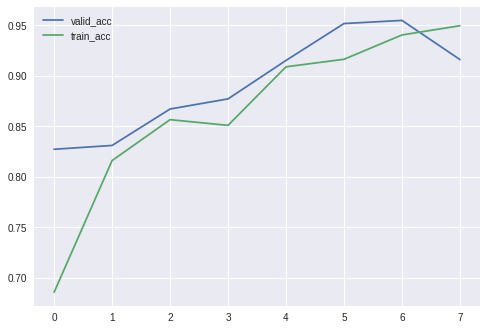

In [ ]:
plt.plot(hist.history['val_acc'], label='valid_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()
plt.show()

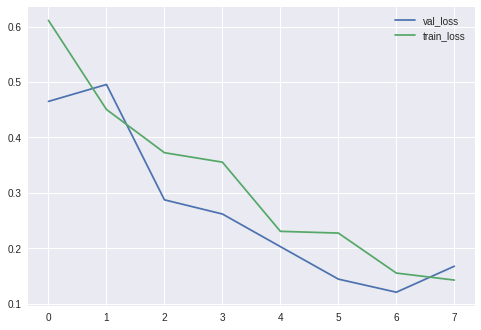

In [ ]:
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()
plt.show()

Tiến hành predict với bộ data test

In [ ]:
model = model.sync_to_cpu()
test_pred = model.predict(test_fit)
test_acc = accuracy_score(np.array(Y_test.tolist()), test_pred.round())
print("Test set acc:", test_acc)
print("Validation set acc:", hist.history['val_acc'][-1])
print('recall:', recall_score(Y_test.to_list(), test_pred.round()))
print('precision:', precision_score(Y_test.to_list(), test_pred.round()))
print('f1:', f1_score(Y_test.to_list(), test_pred.round()))

Test set acc: 0.9046950553735766
Validation set acc: 0.916221
recall: 0.9957055214723927
precision: 0.8446526151444185
f1: 0.9139800084471351


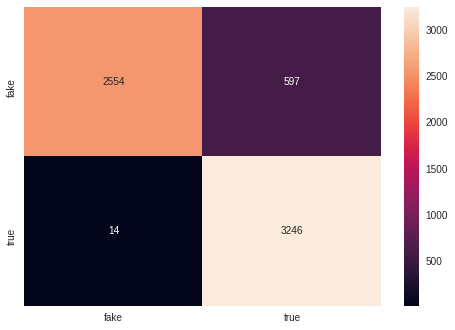

In [ ]:
matrix = confusion_matrix(np.array(Y_test.tolist()), test_pred.round())
df_cm = pd.DataFrame(matrix, columns=['fake', 'true'], index=['fake', 'true'])
seaborn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

LSTM


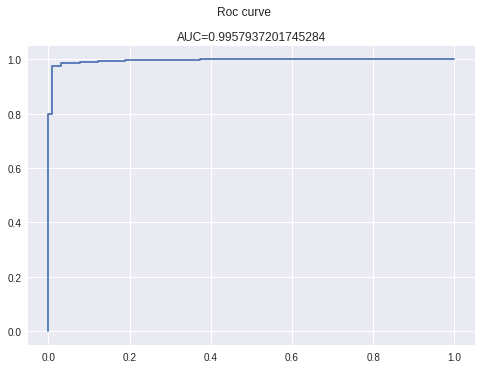

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, test_pred)
auc = metrics.roc_auc_score(Y_test, test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')

print("LSTM")
ax.plot(fpr,tpr)
plt.show()

In [ ]:
model.save('drive/My Drive/ColabNotebooks/VietnameseFakeNews/Models/fakenews1905.h5')